In [1]:
import os 

import numpy as np
import scipy.stats as sps
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

import sys, os
sys.path += [os.path.abspath(os.pardir + '/code')]
print(sys.path)

from experiment import init_random_state, BanditLoopExperiment, get_ts_model

sns.set(font_scale=1.2, palette='tab20') 

['/home/anton/Desktop/m1p/2021-Project-74/notebooks', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/anton/.local/lib/python3.8/site-packages', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages', '/home/anton/.local/lib/python3.8/site-packages/IPython/extensions', '/home/anton/.ipython', '/home/anton/Desktop/m1p/2021-Project-74/code']


In [2]:
seed = 42

p = 0.9
Q = 1
w = 4
b = 0.0

T = 2000

ws = []
M, l = 10, 4
for w in np.arange(1, 8):
    for p in np.linspace(0.5, 1., 5):
        ws.append((w, p))
print(ws)

[(1, 0.5), (1, 0.625), (1, 0.75), (1, 0.875), (1, 1.0), (2, 0.5), (2, 0.625), (2, 0.75), (2, 0.875), (2, 1.0), (3, 0.5), (3, 0.625), (3, 0.75), (3, 0.875), (3, 1.0), (4, 0.5), (4, 0.625), (4, 0.75), (4, 0.875), (4, 1.0), (5, 0.5), (5, 0.625), (5, 0.75), (5, 0.875), (5, 1.0), (6, 0.5), (6, 0.625), (6, 0.75), (6, 0.875), (6, 1.0), (7, 0.5), (7, 0.625), (7, 0.75), (7, 0.875), (7, 1.0)]


In [3]:
interests, responses = [], []

In [4]:
for i, (w, p) in enumerate(ws):
    init_random_state(seed)
    
    bandit = lambda: get_ts_model(M=M, l=l)
    exp = BanditLoopExperiment(bandit, "TS bandit")
    exp.prepare(w=w, Q=Q, p=p, b=b)
    exp.run_experiment(T=T)
    
    results = exp.get_as_np()
    interests.append(results.interest)
    responses.append(results.response)

In [5]:
responses[4].shape

(2000, 4)

In [6]:
sum_responces = []
for i in range(len(ws)):  
    sum_responces.append(np.cumsum(responses[i].reshape(2000, -1).sum(axis=1)))

sum_responces = np.array(sum_responces)
sum_responces.shape

(35, 2000)

In [7]:
sum_interests = []
for i in range(len(ws)):  
    sum_interests.append(np.linalg.norm(interests[i] - interests[i][0], axis=1)**2)
    
sum_interests = np.array(sum_interests)
sum_interests.shape

(35, 2000)

In [9]:
np.vstack([np.concatenate(sum_interests).reshape(1, -1), np.concatenate(sum_responces).reshape(1, -1)]).shape

(2, 70000)

In [10]:
data = pd.DataFrame(np.vstack([np.concatenate(sum_interests).reshape(1, -1), np.concatenate(sum_responces).reshape(1, -1)]).T, columns=['Norm interests', 'Sum response']) 
data['w'] = 0
data['p'] = 0
data['t'] = 0
for i, (w, p) in enumerate(ws):
    data['w'][i*T:(i+1)*T] = w
    data['p'][i*T:(i+1)*T] = p
    data['t'][i*T:(i+1)*T] = np.arange(T)+1

<ipython-input-10-a47b3a1a68fb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['w'][i*T:(i+1)*T] = w
/home/anton/.local/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-10-a47b3a1a68fb>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['p'][i*T:(i+1)*T] = p
<ipython-input-10-a47b3a1a68fb>:8: SettingWithCopyWarning:

In [13]:
last_val = data[data['t']==T]

In [31]:
from matplotlib import ticker

(5, 7)


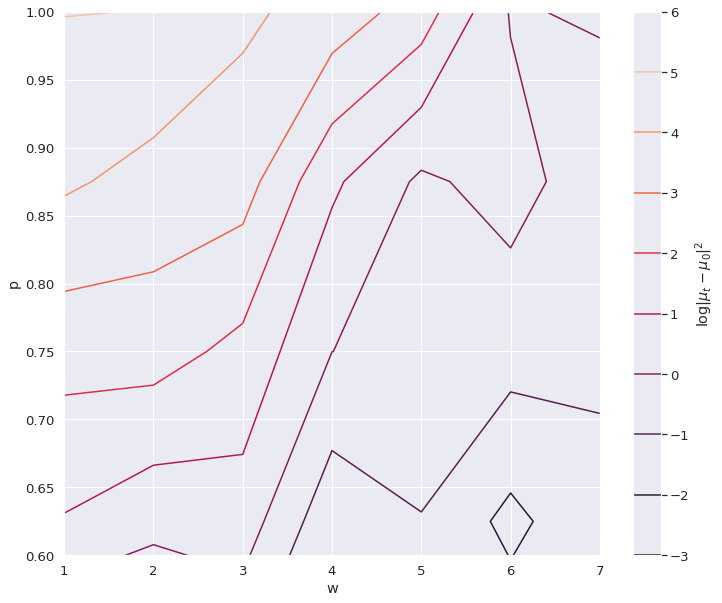

In [43]:
fig = plt.figure(figsize=(12,10))
x, y = np.meshgrid(np.arange(1,8), np.linspace(0.5, 1., 5))
z = np.empty((5,7))

print(x.shape)

for i in range(5):
    for j  in range(7):
        z[i, j] = last_val[(last_val['w']==x[i,j]) & (last_val['p']==y[i,j])]['Norm interests']

plt.xlim((1,7))
plt.ylim((0.6,1.))

plt.xlabel('w')
plt.ylabel('p')
ax = plt.contour(x, y, np.log(z))

cbar = fig.colorbar(ax)
cbar.set_label(r'$\log \|\mu_t - \mu_0 \|^2$')
plt.savefig('plot_wp.pdf')

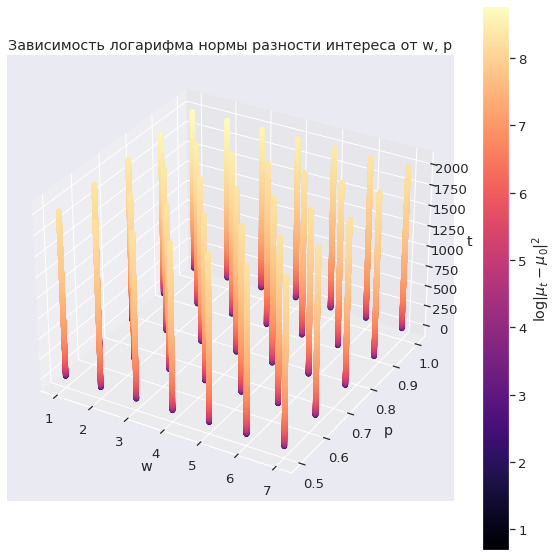

In [37]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection = '3d')

z = data['t']
x = data['w']
y = data['p']
c = data['Sum response']

ax.set_xlabel("w")
ax.set_ylabel("p")
ax.set_zlabel("t")

p = ax.scatter(x, y, z, c=np.log(c), cmap='magma')
plt.title('Зависимость логарифма нормы разности интереса от w, p')
cbar = fig.colorbar(p, ax=ax)
cbar.set_label(r'$\log \|\mu_t - \mu_0 \|^2$')

plt.savefig('3d_plot_wp.pdf')
plt.show()